<img src="http://nci.org.au/wp-content/themes/nci/img/img-logo-large.png", width=400>

---------

# Programmatically accessing data through THREDDS and the VDI
## ...using Python 3


### In this notebook:

- <a href='#part1'>Using the Siphon Python package to programmatically access THREDDS data service endpoints</a>
- <a href='#part2'>Programmatically accessing files from the VDI</a>


#### The following material uses CSIRO IMOS TERN-AusCover MODIS Data Collection. For more information on the collection and licensing, please [click here](https://geonetwork.nci.org.au/geonetwork/srv/eng/catalog.search#/metadata/f6406_5388_2095_4364). 


### Prerequisites:

- A python 3 virtual environment with the following Python modules loaded:
    - matplotlib
    - netcdf4
    - siphon
    - shapely
    - requests

#### Setup instructions for python 3 virtual environments can be found [here](https://nbviewer.jupyter.org/github/adamsteer/nci-notebooks/blob/master/training/py3/VDI_Python3.ipynb).

---------

<br>


### Import python packages

In [4]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt 
from siphon import catalog, ncss
import datetime
%matplotlib inline

### Start by defining the parent catalog URL from NCI's THREDDS Data Server
**Note:** Switch the '.html' ending on the URL to '.xml' 

In [5]:
url = 'http://dapds00.nci.org.au/thredds/catalog/u39/public/data/modis/fractionalcover-clw/v2.2/netcdf/catalog.xml'

<a id='part1'></a> 
## Using Siphon

Siphon is a collection of Python utilities for downloading data from Unidata data technologies. More information on installing and using Unidata's Siphon can be found: 
https://github.com/Unidata/siphon


Once selecting a parent dataset directory, Siphon can be used to search and use the data access methods and services provided by THREDDS. For example, Siphon will return a list of data endpoints for the OPeNDAP data URL, NetCDF Subset Service (NCSS), Web Map Service (WMS), Web Coverage Service (WCS), and the HTTP link for direct download. 

In this Notebook, we'll be demonstrating the Netcdf Subset Service (NCSS). 

In [6]:
tds = catalog.TDSCatalog(url)
datasets = list(tds.datasets)
endpts = list(tds.datasets.values())

In [7]:
list(tds.datasets.keys())

['FractCover.V2_2.2000.049.aust.005.nc.gz',
 'FractCover.V2_2.2000.057.aust.005.nc.gz',
 'FractCover.V2_2.2000.065.aust.005.nc.gz',
 'FractCover.V2_2.2000.073.aust.005.nc.gz',
 'FractCover.V2_2.2000.081.aust.005.nc.gz',
 'FractCover.V2_2.2000.089.aust.005.nc.gz',
 'FractCover.V2_2.2000.097.aust.005.nc.gz',
 'FractCover.V2_2.2000.105.aust.005.nc.gz',
 'FractCover.V2_2.2000.113.aust.005.nc.gz',
 'FractCover.V2_2.2000.121.aust.005.nc.gz',
 'FractCover.V2_2.2000.129.aust.005.nc.gz',
 'FractCover.V2_2.2000.137.aust.005.nc.gz',
 'FractCover.V2_2.2000.145.aust.005.nc.gz',
 'FractCover.V2_2.2000.153.aust.005.nc.gz',
 'FractCover.V2_2.2000.161.aust.005.nc.gz',
 'FractCover.V2_2.2000.169.aust.005.nc.gz',
 'FractCover.V2_2.2000.177.aust.005.nc.gz',
 'FractCover.V2_2.2000.185.aust.005.nc.gz',
 'FractCover.V2_2.2000.193.aust.005.nc.gz',
 'FractCover.V2_2.2000.201.aust.005.nc.gz',
 'FractCover.V2_2.2000.209.aust.005.nc.gz',
 'FractCover.V2_2.2000.217.aust.005.nc.gz',
 'FractCover.V2_2.2000.225.aust.

##### The possible data services end points through NCI's THREDDS includes: OPeNDAP, Netcdf Subset Service (NCSS), HTTP download, Web Map Service (WMS), Web Coverage Service (WCS), NetCDF Markup Language (NcML), and a few metadata services (ISO, UDDC). 

In [8]:
for key, value in endpts[0].access_urls.items():
    print('{}, {}'.format(key, value))

UDDC, http://dapds00.nci.org.au/thredds/uddc/u39/public/data/modis/fractionalcover-clw/v2.2/netcdf/FractCover.V2_2.2000.049.aust.005.nc.gz
ISO, http://dapds00.nci.org.au/thredds/iso/u39/public/data/modis/fractionalcover-clw/v2.2/netcdf/FractCover.V2_2.2000.049.aust.005.nc.gz
HTTPServer, http://dapds00.nci.org.au/thredds/fileServer/u39/public/data/modis/fractionalcover-clw/v2.2/netcdf/FractCover.V2_2.2000.049.aust.005.nc.gz
WMS, http://dapds00.nci.org.au/thredds/wms/u39/public/data/modis/fractionalcover-clw/v2.2/netcdf/FractCover.V2_2.2000.049.aust.005.nc.gz
NetcdfSubset, http://dapds00.nci.org.au/thredds/ncss/u39/public/data/modis/fractionalcover-clw/v2.2/netcdf/FractCover.V2_2.2000.049.aust.005.nc.gz
WCS, http://dapds00.nci.org.au/thredds/wcs/u39/public/data/modis/fractionalcover-clw/v2.2/netcdf/FractCover.V2_2.2000.049.aust.005.nc.gz
NCML, http://dapds00.nci.org.au/thredds/ncml/u39/public/data/modis/fractionalcover-clw/v2.2/netcdf/FractCover.V2_2.2000.049.aust.005.nc.gz
OPENDAP, http

### We can create a small function that uses Siphon's Netcdf Subset Service (NCSS) to extract a spatial request (defined by a lat/lon box)

In [9]:
def get_data(dataset, bbox):    
    nc = ncss.NCSS(dataset.access_urls['NetcdfSubset'])
    query = nc.query()
    query.lonlat_box(north=bbox[3],south=bbox[2],east=bbox[1],west=bbox[0])
    query.variables('bs')
    
    data = nc.get_data(query)
    
    lon = data['longitude'][:]
    lat = data['latitude'][:]
    bs = data['bs'][0,:,:]
    t = data['time'][:]
    
    time_base = datetime.date(year=1800, month=1, day=1)
    time = time_base + datetime.timedelta(t[0])
    
    return lon, lat, bs, time

### Query a single file and view result

In [10]:
bbox = (135, 140, -31, -27)
lon, lat, bs, t = get_data(endpts[0], bbox)

Date: 2000-02-18


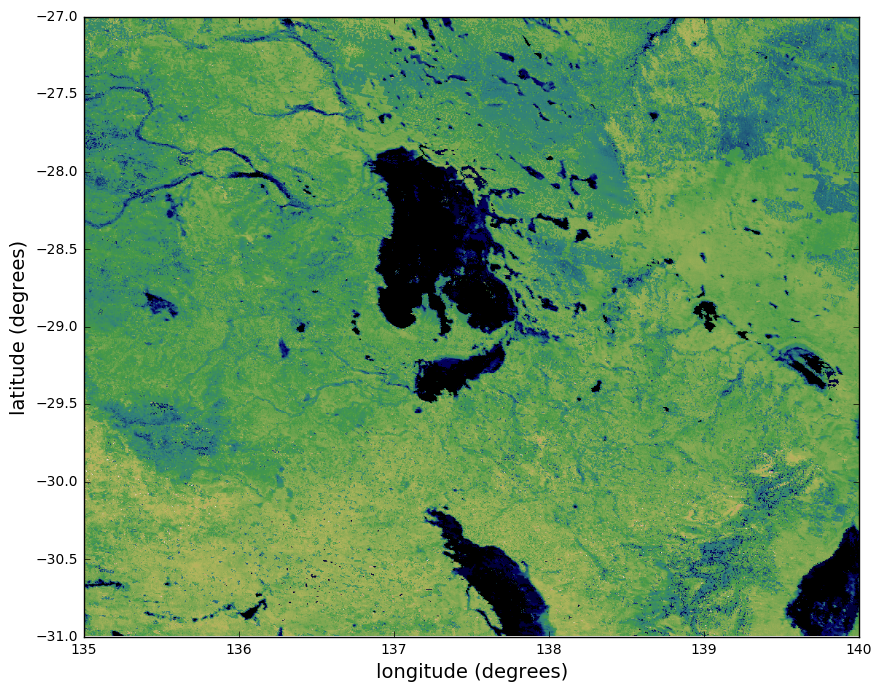

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(bs, extent=bbox, cmap='gist_earth', origin='upper')

plt.xlabel('longitude (degrees)', fontsize=14)
plt.ylabel('latitude (degrees)', fontsize=14)
print("Date: {}".format(t))

### Loop and query over the collection

In [12]:
bbox = (135, 140, -31, -27)
plt.figure(figsize=(10,10))

for endpt in endpts[:15]:
    try:
        lon, lat, bs, t = get_data(endpt, bbox)

        plt.imshow(bs, extent=bbox, cmap='gist_earth', origin='upper')
        plt.clim(vmin=-2, vmax=100)

        plt.tick_params(labelsize=14)
        plt.xlabel('longitude (degrees)', fontsize=14)
        plt.ylabel('latitude (degrees)', fontsize=14)

        plt.title("Date: "+str(t), fontsize=16, weight='bold')
        plt.savefig("./images/"+endpt.name+".png")
        plt.cla()
    except:
        pass

plt.close()

### Can make an animation of the temporal evolution (this example is by converting the series of *.png files above into a GIF)
<img src="./images/animated.gif">

### Can also use Siphon to extract a single point

In [13]:
def get_point(dataset, lat, lon):
    nc = ncss.NCSS(dataset.access_urls['NetcdfSubset'])
    query = nc.query()
    query.lonlat_point(lon, lat)
    query.variables('bs')
    
    data = nc.get_data(query)
    bs = data['bs'][0]
    date = data['date'][0]
    
    return bs, date

In [14]:
bs, date = get_point(endpts[4], -27.75, 137)
print("{}, {}".format(bs, date))

51.0, 2000-03-21 00:00:00+00:00


### Time series example

In [15]:
data = []
for endpt in endpts[::20]:
    bs, date = get_point(endpt, -27.75, 137)
    data.append([date, bs])

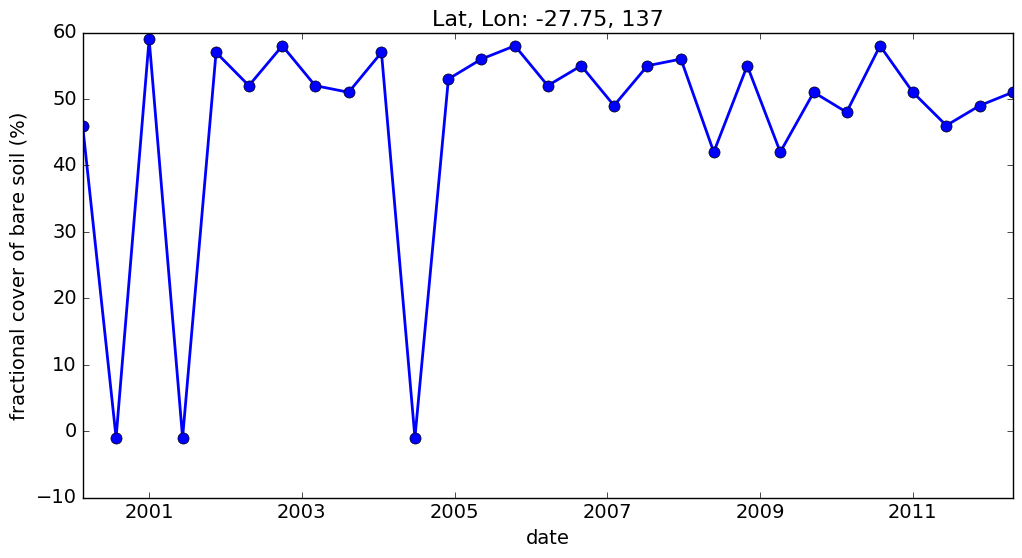

In [16]:
import numpy as np

BS = np.array(data)[:,1]
Date = np.array(data)[:,0]

plt.figure(figsize=(12,6))
plt.plot(Date, BS, '-o', linewidth=2, markersize=8)

plt.tick_params(labelsize=14)
plt.xlabel('date', fontsize=14)
plt.ylabel('fractional cover of bare soil (%)', fontsize=14)
plt.title('Lat, Lon: -27.75, 137', fontsize=16)